### Script to test out if TC track masking is working

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
from matplotlib import ticker, cm
import matplotlib.pyplot as plt
import sys
import cartopy
import subprocess
# from smooth_runn_mn import smooth_runn_mn
from scipy import ndimage
from relvort import relvort
from object_track import object_track
# import cmocean

In [2]:
# TC tracking
ptrack='600' # tracking pressure level
var_track = 'rvor' # variable
rmax = 10 # radius (km) limit to keep unmasked

# #### Time selection

nd = 3 # ndays
nt = nd*24
hr_tag = str(np.char.zfill(str(nt), 2))

t0=36
t0+=1 # add one time step since NCRF(t=0) = CTL
t1 = t0+nt

# #### Directories

figdir = "/home/jamesrup/figures/tc/ens/haiyan/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"

datdir2 = 'post/d02/'

datdir = main+'memb_01/ctl/'+datdir2

In [3]:
##### Get dimensions
process = subprocess.Popen(['ls '+main+'haiyan/memb_01/ctl/wrfout_d02_*'],shell=True,
    stdout=subprocess.PIPE,universal_newlines=True)
output = process.stdout.readline()
wrffil = output.strip() #[3]
varfil_main = Dataset(wrffil)
lat = varfil_main.variables['XLAT'][:][0] # deg
lon = varfil_main.variables['XLONG'][:][0] # deg
lat1d = lat[:,0]
lon1d = lon[0,:]
nx1 = lat1d.size
nx2 = lon1d.size
varfil_main.close()

datdir = main+'haiyan/memb_01/ctl/'+datdir2
varfil_main = Dataset(datdir+'T.nc')
nz = varfil_main.dimensions['level'].size
pres = varfil_main.variables['pres'][:] # hPa
varfil_main.close()

In [4]:
varfil = Dataset(datdir+'W.nc') # this opens the netcdf file
var = varfil.variables['W'][t0:t1,:,:,:] # m/s
varfil.close()

In [5]:
# Read TC track
track_file = datdir+'../../track_'+var_track+'_'+ptrack+'hPa.nc'
ncfile = Dataset(track_file)
clon = ncfile.variables['clon'][:] # deg
clat = ncfile.variables['clat'][:] # deg
ncfile.close()
# print(clon)

In [12]:
print('doing masking')
lon3d = np.repeat(lon[np.newaxis,:,:], nt, axis=0)
lat3d = np.repeat(lat[np.newaxis,:,:], nt, axis=0)
lon3d -= clon[t0:t1,np.newaxis,np.newaxis]
lat3d -= clat[t0:t1,np.newaxis,np.newaxis]
radius3d = np.sqrt( lon3d**2 + lat3d**2 )
radius4d = np.repeat(radius3d[:,np.newaxis,:,:], nz, axis=1)

var_mask = np.ma.masked_where(radius4d > rmax, var, copy=True)
radmask = np.ma.masked_where(radius4d > rmax, radius4d, copy=True)

doing masking


AttributeError: 'MaskedArray' object has no attribute 'np'

---
### Plotting routines

In [7]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

##### Plot time-varying 3D radius map

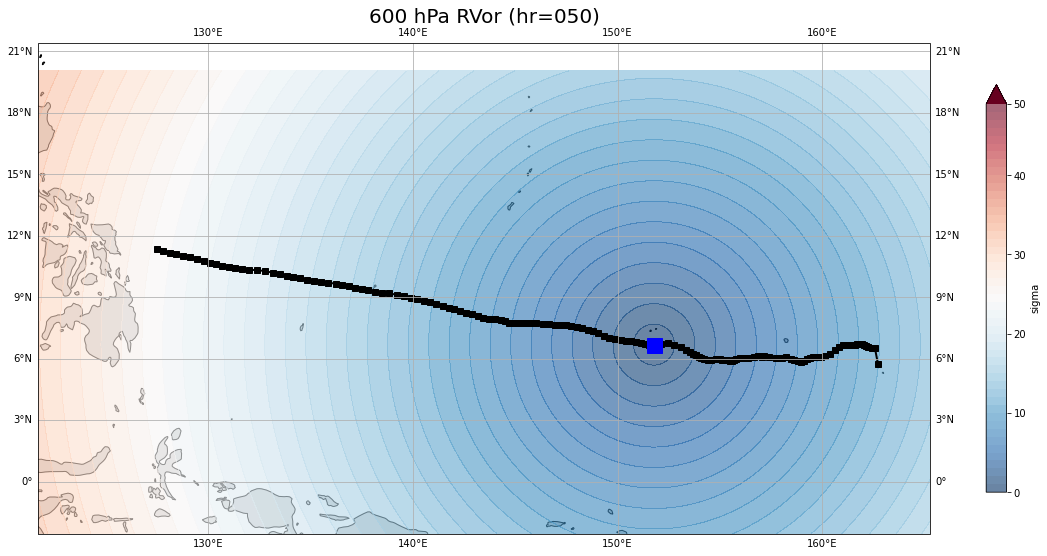

In [8]:
# select plotting area
plt_area=[np.min(lon1d), np.max(lon1d), np.min(lat1d), np.max(lat1d)] # W,E,S,N
# plt_area=[145, np.max(lon), 0, 15] # W,E,S,N

# tsel=36
# for tsel in range(5,nt,6):
for tsel in range(50,51):
    
    hr_tag = str(np.char.zfill(str(tsel), 3))
    
    # iu = u[tsel,:,:]
    # iv = v[tsel,:,:]
    pltvar=radius3d[tsel,:,:]

    # create figure
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111,projection=cartopy.crs.PlateCarree())
    ax.set_title('600' + ' hPa RVor (hr='+hr_tag+')', fontsize=20)

    # fill contour
    clevs = np.arange(0,50)

    im = ax.contourf(lon, lat, pltvar, clevs, cmap='RdBu_r', alpha=0.6,
                     extend='max', zorder=2)

    cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())
    cbar.ax.set_ylabel('sigma')
            # cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator)

    # storm track
    plt.plot(clon, clat, color="black", linewidth=2)
    plt.plot(clon, clat, "s", color="black")
    # current time
    plt.plot(clon[t0+tsel], clat[t0+tsel], "s", color="blue", markersize=15)
    # all-time max (time step 168)
    # plt.plot(lon1d[mloc2[2]], lat1d[mloc2[1]], "s", color="blue", markersize=15)

    # add map features
    ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
    # ax.add_feature(cartopy.feature.OCEAN) #ocean color
    ax.add_feature(cartopy.feature.COASTLINE)
    # ax.add_feature(cartopy.feature.STATES)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    # Zoom into selected area (comment this out to plot entire available area)
    ax.set_extent(plt_area)

    plt.show()
    # plt.close()

##### Plot masked variable radius map

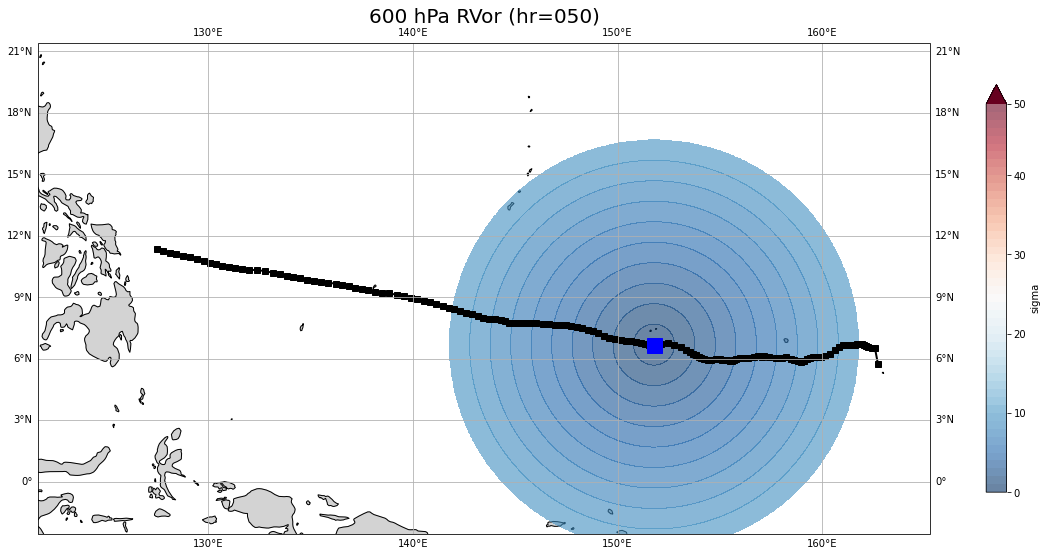

In [9]:
# select plotting area
plt_area=[np.min(lon1d), np.max(lon1d), np.min(lat1d), np.max(lat1d)] # W,E,S,N
# plt_area=[145, np.max(lon), 0, 15] # W,E,S,N

# tsel=36
# for tsel in range(5,nt,6):
for tsel in range(50,51):
    
    hr_tag = str(np.char.zfill(str(tsel), 3))
    
    # iu = u[tsel,:,:]
    # iv = v[tsel,:,:]
#     pltvar=var_mask[tsel,5,:,:]
    pltvar=radmask[tsel,5,:,:]

    # create figure
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111,projection=cartopy.crs.PlateCarree())
    ax.set_title('600' + ' hPa RVor (hr='+hr_tag+')', fontsize=20)

    # fill contour
    clevs = np.arange(0,50)

    im = ax.contourf(lon, lat, pltvar, clevs, cmap='RdBu_r', alpha=0.6,
                     extend='max', zorder=2)

    cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())
    cbar.ax.set_ylabel('sigma')
            # cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator)

    # storm track
    plt.plot(clon, clat, color="black", linewidth=2)
    plt.plot(clon, clat, "s", color="black")
    # current time
    plt.plot(clon[t0+tsel], clat[t0+tsel], "s", color="blue", markersize=15)
    # all-time max (time step 168)
    # plt.plot(lon1d[mloc2[2]], lat1d[mloc2[1]], "s", color="blue", markersize=15)

    # add map features
    ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
    # ax.add_feature(cartopy.feature.OCEAN) #ocean color
    ax.add_feature(cartopy.feature.COASTLINE)
    # ax.add_feature(cartopy.feature.STATES)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    # Zoom into selected area (comment this out to plot entire available area)
    ax.set_extent(plt_area)

    plt.show()
    # plt.close()